In [1]:
import glob
import cv2
import random
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
images=glob.glob("data\*.jpg")
iimages=sorted(images, key=lambda s:int(re.search(r'\d+',s).group()))

In [3]:
im0=cv2.imread(iimages[191])
im1=cv2.imread(iimages[192])
im2=cv2.imread(iimages[193])

In [4]:
sift=cv2.SIFT_create(5000)
k1,d1= sift.detectAndCompute(im1,None)
k2,d2= sift.detectAndCompute(im2,None)

matcher= cv2.BFMatcher()
matches= matcher.knnMatch(d1,d2,k=2)
distances=[]
pts=[]
good=[]
for m,n in matches:
    if m.distance<0.75*n.distance:
        q=m.queryIdx
        t=m.trainIdx
        pos1=np.round(k1[q].pt).astype(int)
        pos2=np.round(k2[t].pt).astype(int)
        pts.append((pos1,pos2))
        dist=np.sqrt((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)
        distances.append(dist)
        good.append(m)
moy_dist=np.mean(distances)
pts=np.array(pts)
print(len(good))
print(moy_dist)

382
630.4788692240855


In [5]:
best=[good[i] for i,n in enumerate(distances) if abs(moy_dist-n)<0.25*moy_dist]
print(len(best))

323


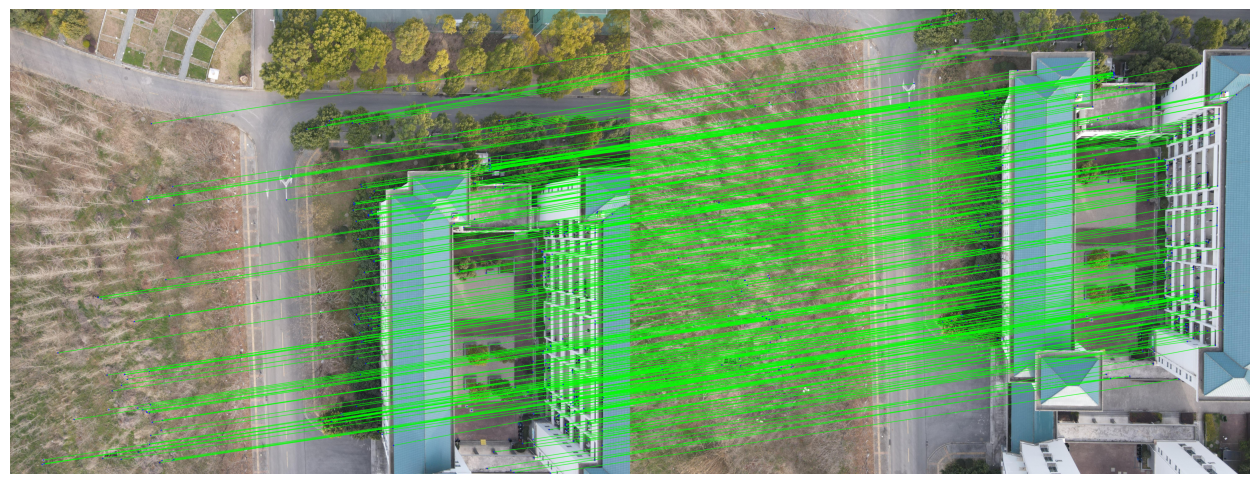

In [6]:
match_img = cv2.drawMatches(im1, k1, im2, k2, best, None,
                                    matchesMask=None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
h1, w1 = im1.shape[:2]
for i, m in enumerate(best):
    
    pt1 = tuple(np.round(k1[m.queryIdx].pt).astype(int))
    pt2 = tuple(np.round(k2[m.trainIdx].pt).astype(int))
    pt2_shifted = (int(pt2[0] + w1), int(pt2[1]))  # car concaténation horizontale

    cv2.line(match_img, pt1, pt2_shifted, (0,255,0), thickness=2, lineType=cv2.LINE_AA)
    cv2.circle(match_img, pt1, 4, (255,0,0), -1)
    cv2.circle(match_img, pt2_shifted, 4, (255,0,0), -1)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [6]:
src=np.float32([k1[m.queryIdx].pt for m in best]).reshape(-1,1,2)
dst=np.float32([k2[m.trainIdx].pt for m in best]).reshape(-1,1,2)

H, _= cv2.findHomography(src,dst,cv2.RANSAC, 5.0)

In [7]:
h1,w1=im1.shape[:2]
h2,w2=im2.shape[:2]

In [18]:
im1.shape

(3000, 4000, 3)

In [8]:
pts_img1 = np.array([
    [0, 0],
    [w1, 0],
    [w1, h1],
    [0, h1]
], dtype=np.float32).reshape(-1, 1, 2)

pts_img2 = np.array([
    [0, 0],
    [w2, 0],
    [w2, h2],
    [0, h2]
], dtype=np.float32).reshape(-1, 1, 2)

proj_pts = cv2.perspectiveTransform(pts_img1, H)

In [85]:
proj_pts

array([[[  24.232666, -627.87524 ]],

       [[4037.2974  , -592.8606  ]],

       [[3994.4382  , 2418.332   ]],

       [[ -10.057193, 2391.7336  ]]], dtype=float32)

In [9]:
all_pts = np.concatenate((proj_pts, pts_img1), axis=0).reshape(-1, 2)

In [92]:
np.floor(np.min(proj_pts, axis=0)).astype(int)[0]

array([ -11, -628])

In [10]:
[xmin, ymin] = np.floor(np.min(proj_pts, axis=0)).astype(int)[0]
[xmax, ymax] = np.ceil(np.max(proj_pts, axis=0)).astype(int)[0]

# Translation pour éviter les coordonnées négatives
tx, ty = -xmin, -ymin
T = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
])


In [11]:
canvas_w = xmax - xmin
canvas_h = ymax - ymin
print(canvas_h,canvas_w)

3047 4049


In [12]:
offset = np.array([-xmin, -ymin], dtype=int)

In [13]:
img1_position = offset

# Position d’img1 via H + offset
translated_corners_img1 = (proj_pts + offset).astype(int)

# Créer le canvas
canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)

In [14]:
from tqdm import tqdm

In [15]:
[x_min, y_min] = np.int32(proj_pts.min(axis=0).ravel())
[x_max, y_max] = np.int32(proj_pts.max(axis=0).ravel())
translation_dist = [-x_min,-y_min]
H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

In [69]:
translation_dist

[10, 627]

In [70]:
x_max,y_max

(4037, 2418)

In [16]:
output_img2 = cv2.warpPerspective(im1, H_translation.dot(H), (x_max-x_min, y_max-y_min))

In [17]:
test=cv2.warpPerspective(im1, H, (x_max, y_max))

In [76]:
x_max

4037

In [78]:
w2

4000

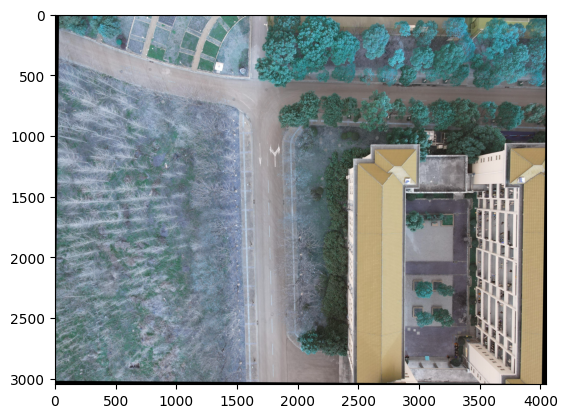

In [123]:
plt.imshow(output_img2)
plt.show()

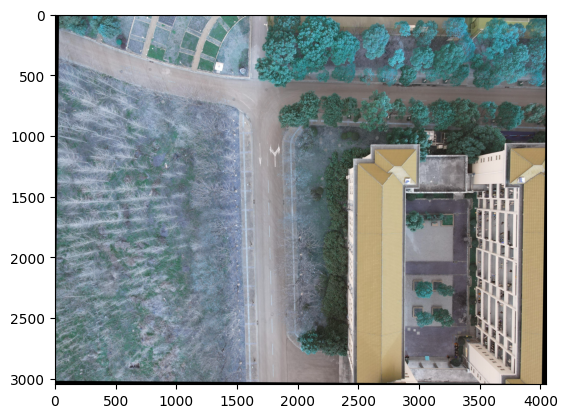

In [102]:
plt.imshow(output_img)
plt.show()

In [18]:
h1,w1=output_img.shape[:2]
h2,w2=im2.shape[:2]

In [29]:
print(h1,w1,h2,w2)

3045 4047 3000 4000


In [18]:
pairs=[]
for m in best:
    x,y=k1[m.queryIdx].pt

    src_pt = np.array([[x, y]], dtype=np.float32).reshape(1, 1, 2)
    new = cv2.perspectiveTransform(src_pt, H_translation.dot(H)).reshape(2,)
    x,y=k2[m.trainIdx].pt
    old=np.array([x,y], dtype=np.float32)
    pairs.append(np.array([new,old]))
pairs=np.array(pairs)

In [19]:
dx, dy = np.mean([ (x2 - x1, y2 - y1) for (x1, y1), (x2, y2) in pairs ], axis=0)
dx, dy = int(round(dx)), int(round(dy))

In [22]:
print(dx,dy)

-9 -661


In [20]:
#
canvas_w=max(w1,w2)+abs(dx)
canvas_h=max(h1,h2)+abs(dy)

In [23]:
canvas_w=w1-dx
canvas_h=h1-dy

In [21]:
#
canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)

In [25]:
canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)

In [22]:
#
canvas[-min(dy,0):h2-min(dy,0),-min(dx,0):w2-min(dx,0)]=im2

In [26]:
canvas[:h1,:w1]=output_img

In [60]:
def fusion1(canv,crop,h,w,dy,dx):
    y=max(dy,0)
    x=max(dx,0)
    #mask=np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            if any(crop[i][j]!=[0,0,0]):
                #mask[i][j]=1
                canv[y+i,x+j]=crop[i][j]
    

In [59]:
any(output_img[0][1]==[0,0,0])

True

In [83]:
pts_img1

array([[[   0.,    0.]],

       [[4000.,    0.]],

       [[4000., 3000.]],

       [[   0., 3000.]]], dtype=float32)

In [82]:
proj_pts

array([[[  24.232666, -627.87524 ]],

       [[4037.2974  , -592.8606  ]],

       [[3994.4382  , 2418.332   ]],

       [[ -10.057193, 2391.7336  ]]], dtype=float32)

In [64]:
#
#canvas[max(dy,0):h1+max(dy,0),max(dx,0):w1+max(dx,0)]=output_img
fusion1(canvas,output_img,h1,w1,dy,dx)

KeyboardInterrupt: 

In [27]:
canvas[-dy:h2-dy,-dx:w2-dx]=im2

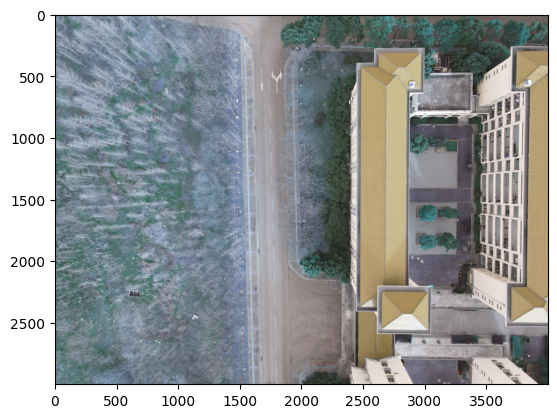

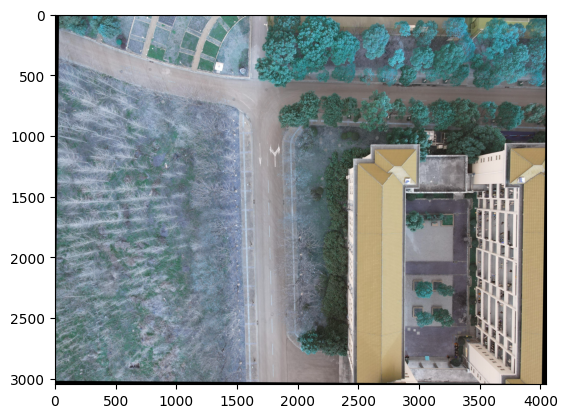

In [121]:
plt.imshow(im2)
plt.show()
plt.imshow(output_img)
plt.show()
# plt.imshow(canvas)
# plt.show()

In [67]:
overlapping1=output_img[-min(dy,0):h1-max(dy,0),-min(dx,0):w1-max(dx,0)]
overlapping2=im2[max(dy,0):h2+min(dy,0),max(dx,0):w2+min(dx,0)]

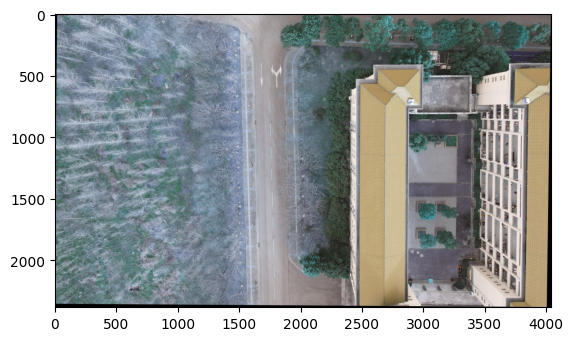

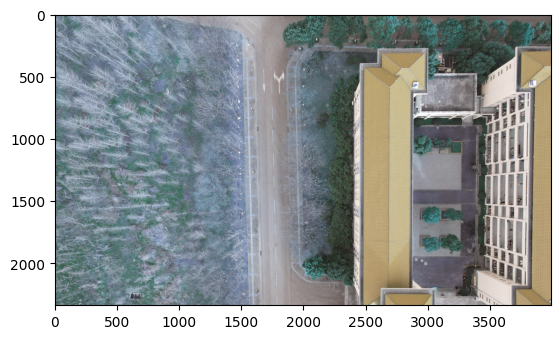

In [68]:
plt.imshow(overlapping1)
plt.show()
plt.imshow(overlapping2)
plt.show()

In [ ]:
def stit(im1,im2):
    sift=cv2.SIFT_create(5000)
    k1,d1= sift.detectAndCompute(im1,None)
    k2,d2= sift.detectAndCompute(im2,None)

    matcher= cv2.BFMatcher()
    matches= matcher.knnMatch(d1,d2,k=2)
    distances=[]
    pts=[]
    good=[]
    for m,n in matches:
        if m.distance<0.75*n.distance:
            q=m.queryIdx
            t=m.trainIdx
            pos1=np.round(k1[q].pt).astype(int)
            pos2=np.round(k2[t].pt).astype(int)
            pts.append((pos1,pos2))
            dist=np.sqrt((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)
            distances.append(dist)
            good.append(m)
    moy_dist=np.mean(distances)
    pts=np.array(pts)
    best=[good[i] for i,n in enumerate(distances) if abs(moy_dist-n)<0.25*moy_dist]

    src=np.float32([k1[m.queryIdx].pt for m in best]).reshape(-1,1,2)
    dst=np.float32([k2[m.trainIdx].pt for m in best]).reshape(-1,1,2)

    H, _= cv2.findHomography(src,dst,cv2.RANSAC, 5.0)

    pts_img1 = np.array([
    [0, 0],
    [w1, 0],
    [w1, h1],
    [0, h1]
    ], dtype=np.float32).reshape(-1, 1, 2)

    # pts_img2 = np.array([
    #     [0, 0],
    #     [w2, 0],
    #     [w2, h2],
    #     [0, h2]
    # ], dtype=np.float32).reshape(-1, 1, 2)

    proj_pts = cv2.perspectiveTransform(pts_img1, H)
    all_pts = np.concatenate((proj_pts, pts_img1), axis=0).reshape(-1, 2)
    [xmin, ymin] = np.floor(np.min(all_pts, axis=0)).astype(int)
    [xmax, ymax] = np.ceil(np.max(all_pts, axis=0)).astype(int)

    # Translation pour éviter les coordonnées négatives
    tx, ty = -xmin, -ymin
    T = np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])
    canvas_w = xmax - xmin
    canvas_h = ymax - ymin
    offset = np.array([-xmin, -ymin], dtype=int)

    [x_min, y_min] = np.int32(proj_pts.min(axis=0).ravel())
    [x_max, y_max] = np.int32(proj_pts.max(axis=0).ravel())
    translation_dist = [-x_min,-y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    output_img = cv2.warpPerspective(im1, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    overlapping1=cv2.warpPerspective(im1, H, (x_max, y_max))
    overlapping2=im2[:max(h1,y_max),:max(w2,x_max)]

    

In [23]:
h1, w1 = im1.shape[:2]
mask1 = np.ones((h1, w1), dtype=np.uint8) * 255
mask_warped = cv2.warpPerspective(mask1, H, dsize=(w2, h2))


In [24]:
H1=np.linalg.inv(H)

In [25]:
mask2= cv2.warpPerspective(mask_warped,H1,dsize=(w1,h1))

In [120]:
mask2

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 194],
       [  0,   0,   0, ..., 255, 255, 192],
       [  0,   0,   0, ..., 200, 200, 151]], dtype=uint8)

In [26]:
output_img = cv2.warpPerspective(im1, H_translation.dot(H), (x_max-x_min, y_max-y_min))

In [27]:
cover2= cv2.bitwise_and(im2, im2, mask=mask_warped)

In [28]:
cover1=cv2.warpPerspective(im1,H,dsize=(w2,h2))

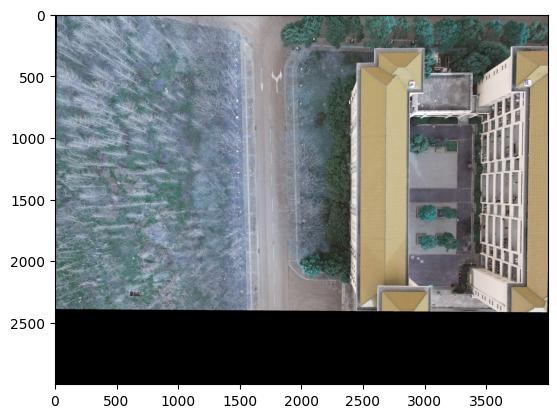

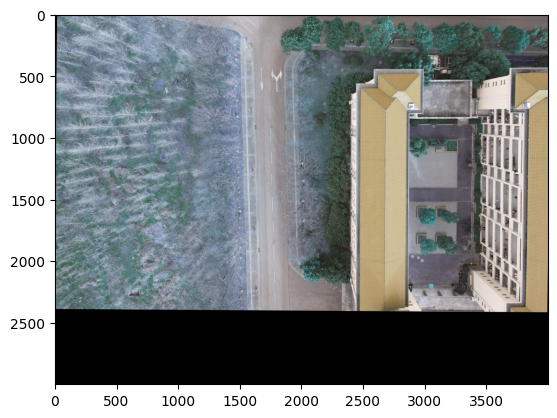

In [29]:
plt.imshow(cover2)
plt.show()
plt.imshow(cover1)
plt.show()

In [30]:
col1 = cv2.cvtColor(cover1, cv2.COLOR_BGR2LAB)
col2 = cv2.cvtColor(cover2, cv2.COLOR_BGR2LAB)
diff_lab = np.linalg.norm(col1.astype(np.float32) - col2.astype(np.float32), axis=2)

In [31]:
blur11 = cv2.GaussianBlur(col1, (5, 5), sigmaX=0.6)
blur12 = cv2.GaussianBlur(col1, (5, 5), sigmaX=1.0)
struct1 = cv2.absdiff(blur11, blur12)

blur21 = cv2.GaussianBlur(col2, (5, 5), sigmaX=0.6)
blur22 = cv2.GaussianBlur(col2, (5, 5), sigmaX=1.0)
struct2 = cv2.absdiff(blur21, blur22)

diff_struct = np.linalg.norm(struct1.astype(np.float32) - struct2.astype(np.float32), axis=2)


In [32]:
# Convertir en niveaux de gris
gray1 = cv2.cvtColor(cover1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(cover2, cv2.COLOR_BGR2GRAY)

# Créer le détecteur de segments de ligne
lsd = cv2.createLineSegmentDetector(0)

# Détection des lignes
lines1 = lsd.detect(gray1)[0]  # [0] contient les lignes détectées ou None
lines2 = lsd.detect(gray2)[0]

# Masques d'accumulation
mask_lines1 = np.zeros_like(gray1, dtype=np.uint8)
mask_lines2 = np.zeros_like(gray2, dtype=np.uint8)

if lines1 is not None:
    lsd.drawSegments(mask_lines1, lines1.astype(np.float32))

if lines2 is not None:
    lsd.drawSegments(mask_lines2, lines2.astype(np.float32))

# Calcul de la différence
diff_lines = cv2.absdiff(mask_lines1, mask_lines2).astype(np.float32)

In [33]:
E=diff_struct+diff_lab+diff_lines

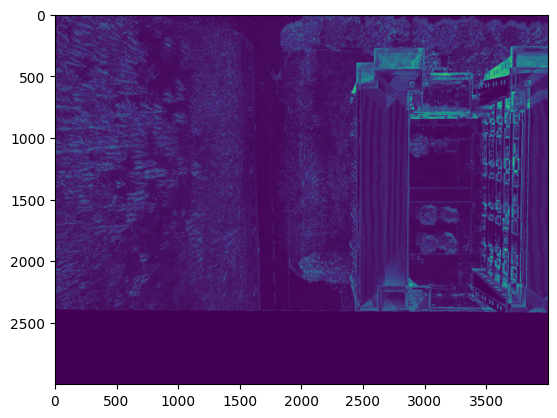

In [34]:
plt.imshow(E)
plt.show()

In [87]:
coords=np.column_stack(np.where(mask_warped>0))

In [134]:
left=int(np.percentile(coords[:,0],25))
right=int(np.percentile(coords[:,0],75))

start=coords[np.where(coords[:,0]==left)[0][0]]
end=coords[np.where(coords[:,0]==right)[0][-1]]

In [135]:
print(start,end)

[602  10] [1804 3999]


In [140]:
flat_E = E[mask_warped > 0].flatten()
thresholds = np.unique(np.sort(flat_E))
low = 0
high = len(thresholds) - 1
best_R = None

In [ ]:
while low <= high:
        mid = (low + high) // 2
        threshold = thresholds[mid]

        # Zone où E < seuil
        R = np.zeros_like(E, dtype=np.uint8)
        R[(E < threshold) & (mask_warped > 0)] = 1

        # Trouver composantes connexes à 8 connexions
        labeled, num = label(R, structure=np.ones((3, 3), dtype=np.uint8))

        label_start = labeled[start_point]
        label_end = labeled[end_point]

        if label_start != 0 and label_start == label_end:
            # Ils sont connectés
            best_R = R.copy()
            high = mid - 1  # Chercher plus petit
        else:
            low = mid + 1

array([ 37.599854,  26.219217,  22.834593, ..., 160.0714  , 159.03647 ,
       185.05048 ], dtype=float32)